# Check the module versions of the HPS solver

In [1]:
import os
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.35"
# os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

import jax
import jax.numpy as jnp
import numpy as np
from scipy.io import savemat
import matplotlib.pyplot as plt

from timeit import default_timer
import logging
logging.basicConfig(
    format="%(asctime)s.%(msecs)03d:jaxhps: %(levelname)s - %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S",
    level=logging.DEBUG
)

from examples.wave_scattering_utils import (
    solve_scattering_problem,
    load_SD_matrices,
    get_uin,
)
from examples.scattering_potentials import (
    q_gaussian_bumps,
)
from examples.plotting_utils import plot_field_for_wave_scattering_experiment

jax.config.update("jax_default_device", jax.devices("gpu")[0])
jax.config.update("jax_enable_x64", True)
# jax.config.update("XLA_PYTHON_CLIENT_MEM_FRACTION", 0.5)


import subprocess
_ =subprocess.run("hostname")
_ =subprocess.run(["nvidia-smi", "--query-gpu=gpu_name,memory.total",  "--format=csv,noheader"])

2025-06-30 12:18:30.112:jaxhps: DEBUG - Creating converter from 7 to 5
2025-06-30 12:18:30.114:jaxhps: DEBUG - Creating converter from 5 to 7
2025-06-30 12:18:30.116:jaxhps: DEBUG - Creating converter from 7 to 5
2025-06-30 12:18:30.117:jaxhps: DEBUG - Creating converter from 5 to 7


g18.ttic.edu
NVIDIA RTX A4000, 16376 MiB


In [2]:
from jaxhps import (
    DiscretizationNode2D,
    Domain,
    PDEProblem,
    upward_pass_subtree,
    downward_pass_subtree,
    local_solve_chunksize_2D,
)
from jaxhps.local_solve import local_solve_stage_uniform_2D_ItI
from jaxhps.merge import merge_stage_uniform_2D_ItI
from jaxhps.down_pass import down_pass_uniform_2D_ItI
from examples.wave_scattering_utils import (
    get_DtN_from_ItI,
    setup_scattering_lin_system,
    get_uin_and_normals,
    get_uin,
    get_scattering_uscat_impedance,
)

from wave_scattering.interp_utils import (
    prep_grids_cheb_2d,
    prep_grids_unif_2d,
)

from wave_scattering.interp_ops import (
    QuadtreeToUniform,
    UniformToQuadtree,
)

In [4]:
bump_center = jnp.array([0.05, 0.1])
# bump_center = jnp.array([0.0, 0.0])
amplitude = 2
sigma = 0.15
q_fn_handle = lambda x: amplitude * jnp.exp(-0.5*jnp.sum( ((x-bump_center)/sigma)**2 ,axis=-1))

# q_fn_handle = lambda x: q_gaussian_bumps(1.5 * x)

In [5]:
tree_n_per_leaf = 16
tree_L = 2
tree_p = 16
tree_n = 2**tree_L * tree_n_per_leaf

domain_bounds = jnp.array([-1., 1., -1., 1.])
tree_root = DiscretizationNode2D(*domain_bounds)
tree_domain = Domain(p=tree_p, q=tree_p-2, root=tree_root, L=tree_L)

print(f"L={tree_L}, N={tree_n}")

L=2, N=64


In [6]:
# Grid setup
cell_offset = 0

# leaf-level
leaf_cheb_grids = prep_grids_cheb_2d(0, tree_p)
leaf_cheb_x  = leaf_cheb_grids[0]
leaf_cheb_y  = leaf_cheb_grids[1]
leaf_cheb_xy = leaf_cheb_grids[2]
leaf_unif_grids = prep_grids_unif_2d(0, tree_n_per_leaf, cell_offset)
leaf_unif_x  = leaf_unif_grids[0]
leaf_unif_y  = leaf_unif_grids[1]
leaf_unif_xy = leaf_unif_grids[2]

# Tree level
tree_cheb_grids = prep_grids_cheb_2d(tree_L, tree_p)
tree_cheb_x  = tree_cheb_grids[0]
tree_cheb_y  = tree_cheb_grids[1]
tree_cheb_xy = tree_cheb_grids[2]

tree_unif_grids = prep_grids_unif_2d(tree_L, tree_n_per_leaf, cell_offset)
tree_unif_x  = tree_unif_grids[0]
tree_unif_y  = tree_unif_grids[1]
tree_unif_xy = tree_unif_grids[2]

In [7]:
%%time
QtU = QuadtreeToUniform(tree_L, tree_p, tree_n_per_leaf, cell_offset=0)

CPU times: user 864 ms, sys: 29.1 ms, total: 893 ms
Wall time: 1.16 s


In [8]:
tree_n_per_leaf

16

In [9]:
4*16

64

In [10]:
%%time
UtQ = UniformToQuadtree(tree_L, tree_p, tree_n_per_leaf, cell_offset=cell_offset)

CPU times: user 2.49 s, sys: 227 ms, total: 2.72 s
Wall time: 1.82 s


In [11]:
# 0. Compute reference values
ref_q_tree_unif = q_fn_handle(tree_unif_xy).reshape(tree_n, tree_n) # .reshape(4**tree_L, -1)
ref_q_tree_cheb = q_fn_handle(tree_domain.interior_points).reshape(4**tree_L, -1)

In [18]:
# 1. Uniform -> Quadtree
q_tree_cheb_utq = UtQ.apply(ref_q_tree_unif)

utq_err = jnp.linalg.norm(ref_q_tree_cheb-q_tree_cheb_utq) / jnp.linalg.norm(ref_q_tree_cheb)
print(f"Uniform->Quadtree relative error: {utq_err:.5e}")

Uniform->Quadtree relative error: 2.01627e-04


In [19]:
# 2. Quadtree -> Uniform (on orig data)
q_unif_qtu_orig = QtU.apply(ref_q_tree_cheb) # .reshape(4**tree_L, -1)

qtu_orig_err = jnp.linalg.norm(ref_q_tree_unif-q_unif_qtu_orig) / jnp.linalg.norm(ref_q_tree_unif)
print(f"Quadtree (orig)->Uniform relative error: {qtu_orig_err:.5e}")

Quadtree (orig)->Uniform relative error: 6.34811e-09


In [20]:
# 3. Quadtree -> Uniform (on Quadtree to Uniform data)
q_unif_qtu_reco = QtU.apply(q_tree_cheb_utq) # .reshape(4**tree_L, -1)

qtu_reco_err = jnp.linalg.norm(ref_q_tree_unif-q_unif_qtu_reco) / jnp.linalg.norm(ref_q_tree_unif)
print(f"Quadtree (reco)->Uniform relative error: {qtu_reco_err:.5e}")

Quadtree (reco)->Uniform relative error: 2.21497e-04


## HPS exterior solver

In [21]:
from exterior_solver.utils.ScatteringProblem import ScatteringProblem
from exterior_solver.utils.gen_SD_exterior import (
    gen_D_exterior,
    gen_S_exterior,
)
from exterior_solver.exterior_solver_for_Olivia import (
    get_uscat_and_dn,
    forward_model_exterior,
)

In [29]:
# Basic problem dimensions
k_str = "20"
k = float(k_str)
R = 100

N_x = 192
L = 4
p = 16 # chebyshev order
pm2 = p-2 # gauss-legendre order
n_per_leaf = int(np.round(N_x / (2**L)))
nside = 2**L
n = nside * n_per_leaf

N_s = 192
N_r = N_s
source_dirs = jnp.pi/2-jnp.linspace(0, 2*jnp.pi, N_s, endpoint=False)
# source_dirs = jnp.linspace(0, 2*jnp.pi, N_s, endpoint=False)

# q_fn = lambda x: q_gaussian_bumps(0.7*x)
q_fn = q_fn_handle
domain_bounds = jnp.array([-0.5, 0.5, -0.5, 0.5])
main_root = DiscretizationNode2D(*domain_bounds)
main_domain = Domain(p=p, q=p - 2, root=main_root, L=L)

main_unif_x, main_unif_y, main_unif_xy = prep_grids_unif_2d(L, n_per_leaf, rel_offset=0)
main_cheb_x, main_cheb_y, main_cheb_xy = prep_grids_cheb_2d(L, p)

ref_main_q_cheb = q_fn(main_domain.interior_points)
ref_main_q_unif = q_fn(main_unif_xy).reshape(N_x, N_x) # .reshape(4**L, n_per_leaf**2)

In [26]:
%%time
main_QtU = QuadtreeToUniform(L, p, n_per_leaf, cell_offset=0)

CPU times: user 1.08 s, sys: 79.3 ms, total: 1.16 s
Wall time: 1.5 s


In [27]:
%%time
main_UtQ = UniformToQuadtree(L, p, n_per_leaf, cell_offset=0) # slow to set up... maybe can do on the GPU?

CPU times: user 5.13 s, sys: 773 ms, total: 5.9 s
Wall time: 3.16 s


In [30]:
# Load S and D matrices for the boundary integral equation
S_D_matrices_fp = os.path.join(
    "data/wave_scattering/SD_matrices",
    f"SD_k{k_str}_n{pm2}_nside{nside}_dom1.mat"
)
S_int, D_int = load_SD_matrices(S_D_matrices_fp)

# Generate the exterior S, D matrices
S_ext = gen_S_exterior(domain=main_domain, k=k, rad=R, source_dirs=source_dirs)
D_ext = gen_D_exterior(domain=main_domain, k=k, rad=R, source_dirs=source_dirs)

In [37]:
%%time
d_xx_evals = jnp.ones_like(main_domain.interior_points[..., 0])
d_yy_evals = jnp.ones_like(main_domain.interior_points[..., 1])
pde_problem = PDEProblem(
    domain=main_domain,
    D_xx_coefficients=d_xx_evals,
    D_yy_coefficients=d_yy_evals,
    eta=k,
    use_ItI=True,
)

CPU times: user 49.7 ms, sys: 11.8 ms, total: 61.5 ms
Wall time: 39.8 ms


In [33]:
%%time
scat_problem = ScatteringProblem(
    pde_problem=pde_problem,
    S_int=S_int,
    D_int=D_int,
    S_ext=S_ext,
    D_ext=D_ext,
    target_points_reg=None,
    source_dirs=source_dirs,
)

2025-06-30 12:22:31.759:jaxhps: INFO - ScatteringProblem: cheby_weights_2D_rearranged shape: (1, 256)
2025-06-30 12:22:31.830:jaxhps: INFO - ScatteringProblem: self.quad_weights_hps shape: (256, 256)
2025-06-30 12:22:31.832:jaxhps: INFO - ScatteringProblem: self.pde_problem.domain.interior_points.shape: (256, 256, 2)


CPU times: user 354 ms, sys: 24.6 ms, total: 379 ms
Wall time: 451 ms


In [34]:
%%time
usc_ext_hps = forward_model_exterior(
    scattering_problem=scat_problem, q=ref_main_q_cheb,
)

2025-06-30 12:22:33.087:jaxhps: DEBUG - merge_stage_uniform_2D_ItI: T_arr.shape = (256, 56, 56)


CPU times: user 8.97 s, sys: 198 ms, total: 9.17 s
Wall time: 9.98 s


In [35]:
%%time
usc_ext_hps = forward_model_exterior(
    scattering_problem=scat_problem, q=ref_main_q_cheb,
)
d_rs_hps = np.array(usc_ext_hps).T

2025-06-30 12:22:41.834:jaxhps: DEBUG - merge_stage_uniform_2D_ItI: T_arr.shape = (256, 56, 56)


CPU times: user 23.9 ms, sys: 17.9 ms, total: 41.8 ms
Wall time: 478 ms


In [36]:
# Query JAX VRAM usage
gpu_list = [device for device in jax.devices("gpu")]
gpu_stats = [gpu.memory_stats() for gpu in gpu_list]
gpu_vram_use_mb  = [gpu_stat["bytes_in_use"] >> 20 for gpu_stat in gpu_stats]
gpu_vram_limit_mb = [gpu_stat["bytes_limit"] >> 20 for gpu_stat in gpu_stats]
print(f"VRAM Usage per GPU (in MBs): {gpu_vram_use_mb}")

VRAM Usage per GPU (in MBs): [510]


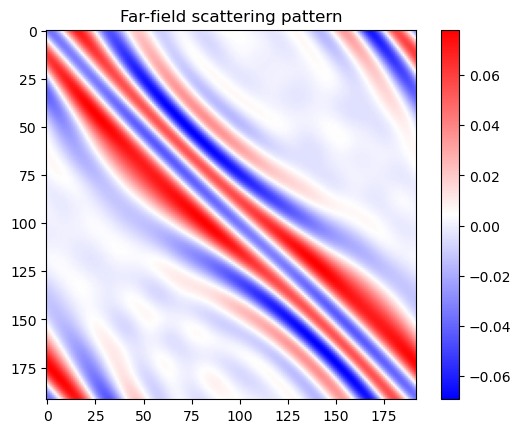

In [38]:
plt.title("Far-field scattering pattern")
plt.imshow(jnp.real(d_rs_hps), cmap="bwr")
plt.colorbar()
plt.show()